<a href="https://colab.research.google.com/github/MariiaKalinina/Elasticity/blob/main/Berryman_SC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Effective elastic moduli for multi-component composite using Berryman’s Consistent

***Rock physics, p.185 : Self-consistent approximations of effective moduli***

Berryman (1980b, 1995) - is one of the Self-consistent approach as Budiansky, 1965; Hill, 1965; Wu, 1966.

Berryman equations are coupled and must be solved by simultaneous iteration.
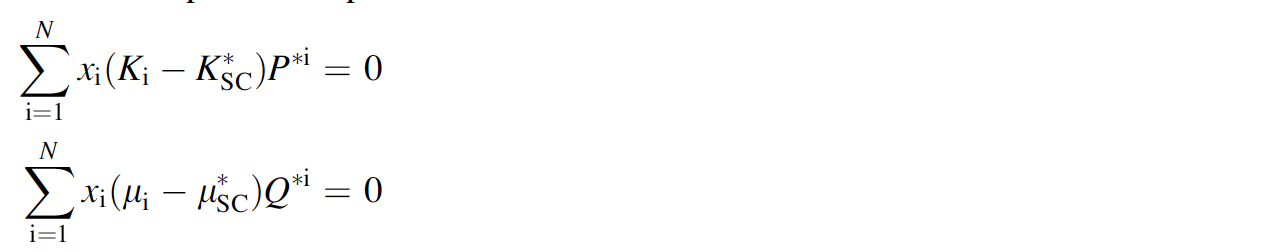

**Assumptions and limitations:**

+ general form of the self-consistent approximations for N-phase composites;
+ for isotropic, linear, elastic media;
+ Самосогласованный метод подходит для сред, где нет четко выраженной матрицы.
+ Изотропный случай: предполагается, что композит является изотропным со случайно ориентированными эллипсоидальными включениями.

- Berryman's self-consistent method **does not converge for fluid disks (Disk --> AR=1)** ($\mu$=0), the formulas for penny-shaped (= penny-cracks , AR $<$ 1) fluid-filled cracks are generally not singular and converge rapidly. However, his estimates for needles, disks, and penny cracks should be used cautiously for fluid-saturated composite materials.

  **Dry cavities??** (=изолированные пустоты) can be modeled by setting the inclusion moduli to zero. Fluidsaturated cavities are simulated by setting the inclusion shear modulus to zero.

+ Apply to simulates very-high-frequency saturated rock behavior (ultrasonic laboratory conditions).

  Because the cavities are isolated with respect to flow, this approach simulates very-high-frequency saturated rock behavior appropriate to ultrasonic laboratory conditions. At low frequencies, when there is time for wave-induced pore-pressure increments to flow and equilibrate, it is better to find the effective moduli for dry cavities and then saturate them with the Gassmann low-frequency relations. This should not be confused with the tendency to term this approach a low-frequency theory, for crack dimensions are assumed to be much smaller than a wavelength.

+ **Анизотропный случай**: В анизотропном случае метод приводит к
системе уравнений, число которых равно числу констант для эквивалентной упругой среды (*Shermergor*). Однако, как было отмечено, например, в работе (*Kachanov M. Eff ective elastic properties of cracked solids: critical
review of some b asic concepts // Applied Mechanics Reviews, 1992, V.45,
issue 8, pp. 304–335*), данный метод переоценивает влияния включений. В случае концентраций пор больших 0,5 метод приводит к отрицательным значениям модулей упругости: ре-
зультат лежит вне вилки Хашина-Штрикмана. В случае высокой концентрации трещин, модули Юнга, объема и сдвига становятся отрицательными, а коэффициент Пуассона превышает 0,5 для насыщенных трещин.




In [38]:
from math import*
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


Self-consistent approximations of effective moduli: Berryman (1980b, 1995), isotropic case.

If $\alpha$ = 1, then apply $\alpha$ = 0.9999 or $\alpha$ = 1.000001

In [8]:
def prolate_common(K_i, Mu_i, AR, K_it, Mu_it): ### --> AR>1


    func_teta = (AR * ((AR ** 2-1) ** (-3 / 2))) * (AR * (AR ** 2-1) ** 0.5-np.arccosh(AR))
    func_f = AR ** 2 * (1-AR ** 2) ** -1 * (3 * func_teta-2)


    v_m = (3 * K_it-2 * Mu_it) / (6 * K_it+2 * Mu_it) ### < -- Poisson ration
    R = (1 - 2*v_m) / (2 *(1-v_m))

    A = Mu_i / Mu_it - 1
    B = 1/3 * ((K_i / K_it)-(Mu_i / Mu_it))

    F1 = 1+A * (1.5 * (func_f+func_teta)-R * (1.5 * func_f+2.5 * func_teta-4 / 3))
    F2 = 1+A * (1+1.5 * (func_f+func_teta)-0.5 * R * (3 * func_f+5 * func_teta))+ \
           B * (3-4 * R)+0.5 * A * (A+3 * B) * (3-4 * R) * (
                   func_f+func_teta-R * (func_f-func_teta+2 * func_teta ** 2))
    F3 = 1+A * (1-(func_f+1.5 * func_teta)+R * (func_f+func_teta))
    F4 = 1+0.25 * A * (func_f+3 * func_teta-R * (func_f-func_teta))
    F5 = A * (-func_f+R * (func_f+func_teta-4 / 3))+B * func_teta * (3-4 * R)
    F6 = 1+A * (1+func_f-R * (func_f+func_teta))+B * (1-func_teta) * (3-4 * R)
    F7 = 2+0.25 * A * (3 * func_f+9 * func_teta-R * (3 * func_f+5 * func_teta))+B * func_teta * (3-4 * R)
    F8 = A * (1-2 * R+0.5 * func_f * (R-1)+0.5 * func_teta * (5 * R-3))+B * (1-func_teta) * (3-4 * R)
    F9 = A * ((R-1) * func_f-R * func_teta)+B * func_teta * (3-4 * R)


    P = 1/3 * (3*F1 / F2)
    Q = 1 / 5 * (2 / F3+1 / F4+((F4 * F5+F6 * F7-F8 * F9) / (F2 * F4)))

    return P, Q


def oblate_common(K_i, Mu_i, AR, K_it, Mu_it): ### < --- oblate - AR < 1
                                              ### <-- K_i, Mu_i: components of medium
                                              ### <-- K_it, Mu_it: effective moduls, that iterate

    func_teta = AR / ((1-AR ** 2) ** (3/2)) * (np.arccos(AR) - AR * (1-AR ** 2) ** 0.5)
    func_f = (AR ** 2 / (1-AR ** 2)) * (3 * func_teta-2)

    v_m = (3 * K_it-2 * Mu_it) / (6 * K_it + 2 * Mu_it)
    R = (1-2 * v_m) / (2 * (1-v_m))

    A = (Mu_i / Mu_it)-1
    B = 1 / 3 * ((K_i / K_it)-(Mu_i / Mu_it))

    F1 = 1+A * (1.5 * (func_f+func_teta)-R * (1.5 * func_f+2.5 * func_teta-4 / 3))
    F2 = 1+A * (1+1.5 * (func_f+func_teta)-0.5 * R * (3 * func_f+5 * func_teta))+ \
           B * (3-4 * R)+0.5 * A * (A+3 * B) * (3-4 * R) * (func_f+func_teta-R * (func_f-func_teta+2 * func_teta ** 2))
    F3 = 1+A * (1-(func_f+1.5 * func_teta)+R * (func_f+func_teta))
    F4 = 1+0.25 * A * (func_f+3 * func_teta-R * (func_f-func_teta))
    F5 = A * (-func_f+R * (func_f+func_teta-4 / 3))+B * func_teta * (3-4 * R)
    F6 = 1+A * (1+func_f-R * (func_f+func_teta))+B * (1-func_teta) * (3-4 * R)
    F7 = 2+0.25 * A * (3 * func_f+9 * func_teta-R * (3 * func_f+5 * func_teta))+B * func_teta * (3-4 * R)
    F8 = A * (1-2 * R+0.5 * func_f * (R-1)+0.5 * func_teta * (5 * R-3))+B * (1-func_teta) * (3-4 * R)
    F9 = A * ((R-1) * func_f-R * func_teta)+B * func_teta * (3-4 * R)

    P = 1/3 * (3*F1/F2)
    Q = 1/5 * (2/F3 + 1/F4 + ((F4 * F5 + F6 * F7 - F8 * F9) / (F2 * F4)))

    return P, Q

In [9]:
def effective_modulus(AR_mtrx, AR_fluid, K_it, Mu_it, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por):

  P_mtrx, Q_mtrx = 0, 0
  P_fl, Q_fl = 0, 0

  if AR_mtrx < 1:
    P_mtrx, Q_mtrx = oblate_common(K_matrix, Mu_matrix, AR_mtrx, K_it, Mu_it)
  elif AR_mtrx == 1:
    AR_mtrx = 1.00001
    P_mtrx, Q_mtrx = prolate_common(K_matrix, Mu_matrix, AR_mtrx, K_it, Mu_it)
  else:
     P_mtrx, Q_mtrx = prolate_common(K_matrix, Mu_matrix, AR_mtrx, K_it, Mu_it)


  if AR_fluid < 1:
    P_fl, Q_fl = oblate_common(K_fluid, Mu_fluid, AR_fluid, K_it, Mu_it)
  elif AR_fluid == 1:
    AR_fluid = 1.00001
    P_fl, Q_fl = prolate_common(K_fluid, Mu_fluid, AR_fluid, K_it, Mu_it)
  else:
    P_fl, Q_fl = prolate_common(K_fluid, Mu_fluid, AR_fluid, K_it, Mu_it)



  Mu = (((1-por) * Mu_matrix * Q_mtrx)+(por * Mu_fluid * Q_fl)) / (
            (1-por) * Q_mtrx + por * Q_fl)  # эффективный модуль сдвига


  K = (((1-por) * K_matrix * P_mtrx)+(por * K_fluid * P_fl)) / (
            (1-por) * P_mtrx + por * P_fl)  # эффективный модуль сжатия


  return K, Mu

In [10]:
def main_Berryman_common(AR_mtrx, AR_fluid, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por):

  K, Mu = 0, 0

  x0, x1 = K_matrix, Mu_matrix ### <--- first initialization
  K_eff, Mu_eff = effective_modulus(AR_mtrx, AR_fluid, x0, x1, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por)


  while abs(x0-K_eff) and abs(x1-Mu_eff) >= eps:
    # print(x0, x1, K_eff, Mu_eff)
    x0, x1 = K_eff, Mu_eff
    K_eff, Mu_eff = effective_modulus(AR_mtrx, AR_fluid, x0, x1, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por)

  K, Mu = K_eff, Mu_eff

  return K, Mu

In [11]:
### Initial data

porosity_range = np.linspace(0.1, 0.1, 1, endpoint=True)
eps = 10**-8  ### точность вычислений в методе самосогласования

# K_fluid, Mu_fluid, pfl  = 0.26, 10**-12, 1.04
# K_matrix, Mu_matrix, pm = 78.18, 27.23, 2.71
# AR_mtrx, AR_fluid = 0.9999, 0.1

K_fluid, Mu_fluid, pfl  = 2.25, 10**-20, 1.04
K_matrix, Mu_matrix, pm = 74.47, 31.99, 2.71
AR_mtrx, AR_fluid = 1, 1

In [12]:
K_value, Mu_value = [], []

for por in porosity_range:

  K, Mu = main_Berryman_common(AR_mtrx, AR_fluid, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por)

  K_value.append(K)
  Mu_value.append(Mu)

### Visualization

In [13]:
# K_fluid, Mu_fluid, pfl  = 10**-6, 10**-6, 1.22 ### air
# K_matrix, Mu_matrix, pm = 53.91, 27.23, 2.71

K_fluid, Mu_fluid, pfl  = 2.25, 10**-20, 1.04 ### water
K_matrix, Mu_matrix, pm = 63.66, 28.62, 2.71

AR_mtrx, AR_fluid = 1, 1
K_value_1, Mu_value_1 = [], []
porosity_range = np.linspace(0., 1, 100, endpoint=True)

for por in porosity_range:

  K, Mu = main_Berryman_common(AR_mtrx, AR_fluid, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por)

  K_value_1.append(K)
  Mu_value_1.append(Mu)

AR_mtrx, AR_fluid = 1.00001, 0.1
K_value_01, Mu_value_01 = [], []

for por in porosity_range:

  K, Mu = main_Berryman_common(AR_mtrx, AR_fluid, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por)

  K_value_01.append(K)
  Mu_value_01.append(Mu)


AR_mtrx, AR_fluid = 1.00001, 0.01
K_value_001, Mu_value_001 = [], []

for por in porosity_range:

  K, Mu = main_Berryman_common(AR_mtrx, AR_fluid, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por)

  K_value_001.append(K)
  Mu_value_001.append(Mu)

Berryman, Isotropic case


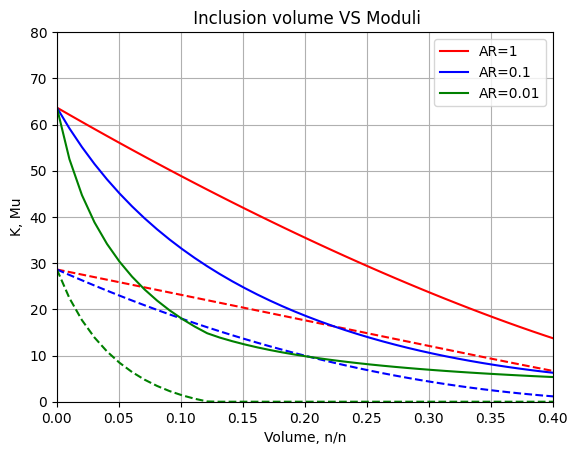

In [14]:
print(f'Berryman, Isotropic case')

plt.plot(porosity_range, K_value_1, label = 'AR=1', color = 'r')
plt.plot(porosity_range, Mu_value_1, 'r--')

plt.plot(porosity_range, K_value_01, label = 'AR=0.1', color='b')
plt.plot(porosity_range, Mu_value_01, 'b--')

plt.plot(porosity_range, K_value_001, label = 'AR=0.01', color='g')
plt.plot(porosity_range, Mu_value_001, 'g--')

plt.title(f' Inclusion volume VS Moduli')
plt.legend()
plt.xlabel('Volume, n/n')
plt.ylabel(f'K, Mu')
plt.xlim(0, 0.4)
plt.ylim(0, 80)
plt.grid()

In [ ]:
def modulus2velosity(density_mtrx, density_fluid, por, K, Mu): ### <-- K, mu to Vp, Vs

    density = density_mtrx * (1-por) + density_fluid * por
    Vp = np.sqrt((K + 4/3*Mu)/ density)
    Vs = np.sqrt(Mu/density)

    return Vp, Vs

In [ ]:
K_value, Mu_value = K_value_01, Mu_value_01

In [ ]:
K_value, Mu_value = K_value_01, Mu_value_01
Vp_value_01, Vs_value_01 = [], []

density_mtrx, density_fluid = pm, pfl

for K,  Mu, porosity in zip(K_value, Mu_value, porosity_range):
  Vp, Vs = modulus2velosity(density_mtrx, density_fluid, porosity, K, Mu)
  Vp_value_01.append(Vp)
  Vs_value_01.append(Vs)

In [ ]:
K_value, Mu_value = K_value_001, Mu_value_001

Vp_value_001, Vs_value_001 = [], []

density_mtrx, density_fluid = pm, pfl

for K,  Mu, porosity in zip(K_value, Mu_value, porosity_range):
  Vp, Vs = modulus2velosity(density_mtrx, density_fluid, porosity, K, Mu)
  Vp_value_001.append(Vp)
  Vs_value_001.append(Vs)

In [ ]:
K_value, Mu_value = K_value_1, Mu_value_1

Vp_value_1, Vs_value_1 = [], []

density_mtrx, density_fluid = pm, pfl

for K,  Mu, porosity in zip(K_value, Mu_value, porosity_range):
  Vp, Vs = modulus2velosity(density_mtrx, density_fluid, porosity, K, Mu)
  Vp_value_1.append(Vp)
  Vs_value_1.append(Vs)

### Наложение экспериментальных данных

In [ ]:
from pathlib import Path
import pandas as pd

path_to_ser = Path('/content/Tver.xlsx')
df_ues = pd.read_excel(path_to_ser, sheet_name='All properties', skiprows=0)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

data = df_ues.copy()
data.drop('#', axis=1, inplace=True)

# Vp, Vs, porosity  = data['Vp air'], data['Vs air'], data['Porosity,%']/100
Vp_exp, Vs_exp, porosity_exp  = data['Vp water'], data['Vs water'], data['Porosity,%']/100

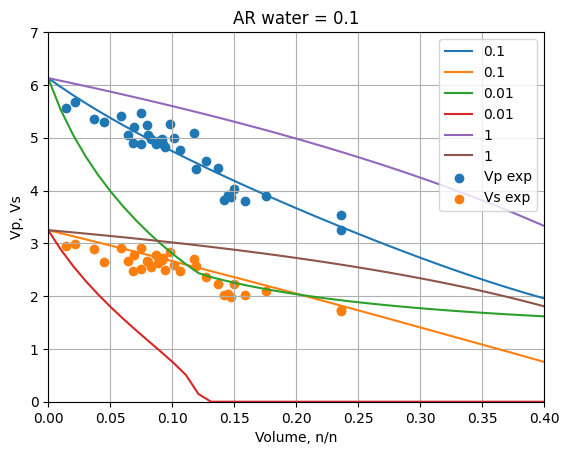

In [ ]:
plt.plot(porosity_range, Vp_value_01, label='0.1')
plt.plot(porosity_range, Vs_value_01, label='0.1')

plt.plot(porosity_range, Vp_value_001, label='0.01')
plt.plot(porosity_range, Vs_value_001, label='0.01')

plt.plot(porosity_range, Vp_value_1, label='1')
plt.plot(porosity_range, Vs_value_1, label='1')

plt.scatter(porosity_exp , Vp_exp, label='Vp exp')
plt.scatter(porosity_exp , Vs_exp, label='Vs exp')

AR_fluid = 0.1
plt.title(f'AR water = {AR_fluid}')
plt.xlim(0, 0.4)
plt.ylim(0, 7)
plt.xlabel('Volume, n/n')
plt.ylabel(f'Vp, Vs')
plt.legend()
plt.grid()

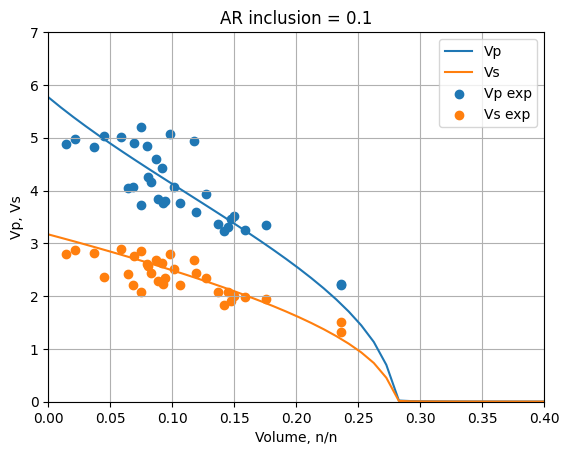

In [ ]:
plt.plot(porosity_range, Vp_value, label='Vp')
plt.plot(porosity_range, Vs_value, label='Vs')

plt.scatter(porosity , Vp, label='Vp exp')
plt.scatter(porosity , Vs, label='Vs exp')

AR_fluid = 0.1
plt.title(f'AR inclusion = {AR_fluid}')
plt.xlim(0, 0.4)
plt.ylim(0, 7)
plt.xlabel('Volume, n/n')
plt.ylabel(f'Vp, Vs')
plt.legend()
plt.grid()

In [ ]:
K_value, Mu_value = [], []

AR_fluid_range = list(np.logspace(-4, 0, num=500, base=10))

AR_mtrx = 1
por = 0.1

for AR_fluid in AR_fluid_range:

  K, Mu = main_Berryman_common(AR_mtrx, AR_fluid, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por)

  K_value.append(K)
  Mu_value.append(Mu)

Berryman, Isotropic case


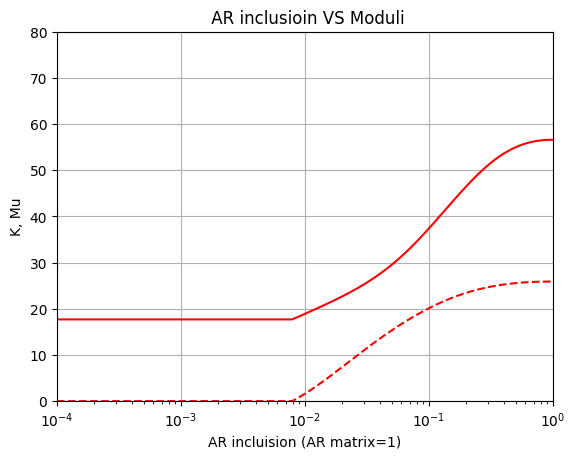

In [ ]:
print(f'Berryman, Isotropic case')

plt.plot(AR_fluid_range , K_value, color = 'r')
plt.plot(AR_fluid_range , Mu_value, 'r--')


plt.title(f' AR inclusioin VS Moduli')
plt.xlabel('AR incluision (AR matrix=1)')
plt.ylabel(f'K, Mu')
plt.xscale("log")
plt.xlim(10**-4, 10**0)
plt.ylim(0, 80)
plt.grid()

### VRH and Hashin-Strikman bourders

In [ ]:
def VRH (K, μ, f):

    K_voit = (f[0]*K[0]) + (f[1]*K[1])

    K_ross = (f[0]/K[0] + f[1]/K[1])**-1

    K_hill = np.mean([K_voit, K_ross])

    μ_voit = (f[0]*μ[0]) + (f[1]*μ[1])

    μ_ross = (f[0]/μ[0] + f[1]/μ[1])**-1

    μ_hill = np.mean([μ_voit, μ_ross])

    return K_voit, K_ross, K_hill, μ_voit, μ_ross, μ_hill

In [ ]:
def HS_borders(K, μ, f):


  K_up = K[0] + (f[1]/((K[1]-K[0])**-1 +
                        f[0]*(K[0]+4/3*μ[0])**-1))

  K_lo = K[1] + (f[0]/((K[0]-K[1])**-1 +
                        f[1]*(K[1]+4/3*μ[1])**-1))

  K_av = np.mean([K_up, K_lo])

  μ_up = μ[0] + ((f[1])/((μ[1]-μ[0])**-1 +
                          2*f[0]*(K[0]+2*μ[0])/(5*μ[0]*(K[0]+4/3*μ[0]))))

  μ_lo = μ[1] + ((f[0])/((μ[0]-μ[1])**-1 +
                          2*f[1]*(K[1]+2*μ[1])/(5*μ[1]*(K[1]+4/3*μ[1]))))
  μ_av = np.mean([μ_up, μ_lo])

  return K_up, K_lo, K_av, μ_up, μ_lo, μ_av

In [ ]:
porosity = np.linspace(0, 1, 100, endpoint=True)
K_up_value, K_lo_value, K_av_value = [], [], []


for phi in porosity:
  K, μ, f = [K_matrix, K_fluid], [Mu_matrix, Mu_fluid], [1-phi, phi]
  K_up, K_lo, K_av, _, _, _ = HS_borders(K, μ, f)
  K_up_value.append(K_up)
  K_lo_value.append(K_lo)
  K_av_value.append(K_av)

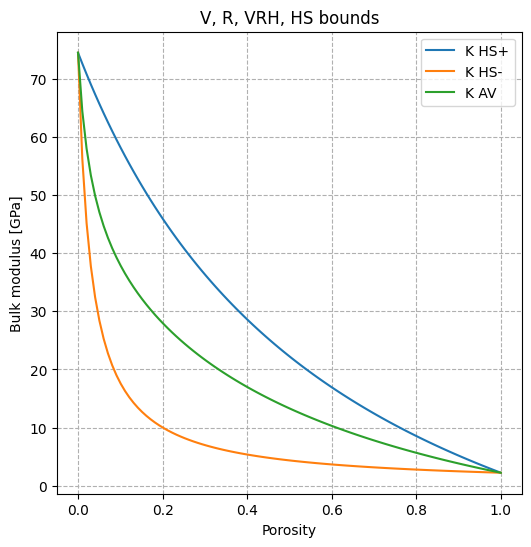

In [ ]:
plt.figure(figsize=(6,6))
plt.xlabel('Porosity')
plt.ylabel('Bulk modulus [GPa]')
plt.title('V, R, VRH, HS bounds')

plt.plot(porosity, K_up_value,label='K HS+')
plt.plot(porosity, K_lo_value,label='K HS-')
plt.plot(porosity, K_av_value,label='K AV')

plt.legend(loc='best')
plt.grid(ls='--')

### Inverse problem: air + water

In [15]:
def velosity2modulus(density, Vp, Vs): ### <-- K, mu to Vp, Vs

    density = 2.71
    с_11 = Vp**2*density
    c_44 = Vs**2*density

    mu = c_44
    K = с_11 - 4/3*mu
    print(с_11,c_44, K, mu)

    return K, mu

In [16]:
Vp_reg_air, Vs_reg_air = 5.77, 3.17
Vp_reg_water, Vs_reg_water = 6.13, 3.25
Vp_reg_oil, Vs_reg_oil = 6.19, 3.39

K_air_mtrx, Mu_air_mtrx = velosity2modulus(2.71, Vp_reg_air, Vs_reg_air)
K_water_mtrx, Mu_water_mtrx = velosity2modulus(2.71, Vp_reg_water, Vs_reg_water)
K_oil_mtrx, Mu_oil_mtrx = velosity2modulus(2.71, Vp_reg_oil, Vs_reg_oil)

90.22375899999999 27.232519 53.91373366666666 27.232519
101.833399 28.624375 63.66756566666667 28.624375
103.83663100000001 31.143591 62.31184300000001 31.143591


In [102]:
K_oil, Mu_oil, p_oil = 0.26, 10**-12, 1.04
K_water, Mu_water, p_water = 2.25, 10**-20, 1.04 ### water
K_air, Mu_air, p_air = 10**-6, 10**-6, 1.22 ### air

In [19]:
def modulus2velosity(density_mtrx, density_fluid, por, K, Mu): ### <-- K, mu to Vp, Vs

    density = density_mtrx * (1-por) + density_fluid * por
    Vp = np.sqrt((K + 4/3*Mu)/ density)
    Vs = np.sqrt(Mu/density)

    return Vp, Vs

In [ ]:
K_value, Mu_value = K_value_01, Mu_value_01
Vp_value_01, Vs_value_01 = [], []

density_mtrx, density_fluid = pm, pfl

for K,  Mu, porosity in zip(K_value, Mu_value, porosity_range):
  Vp, Vs = modulus2velosity(density_mtrx, density_fluid, porosity, K, Mu)
  Vp_value_01.append(Vp)
  Vs_value_01.append(Vs)

In [95]:
porosity = 15.02/100
density_air, density_water = 2.30, 2.29
print(porosity)
AR = np.logspace(1.3, 0.8, num=6)
error = 0.05

0.1502


In [96]:
AR

array([19.95262315, 15.84893192, 12.58925412, 10.        ,  7.94328235,
        6.30957344])

In [104]:
fluid_list = ['air', 'water']

for fluid in fluid_list:

    data_fluid = {

    }

    #     data_fluid = {
    #     f'Vp_{fluid}': [],
    #     f'Vs_{fluid}': []
    # }

    Vp_fluid_list = []
    Vs_fluid_list = []
    AR_list = []
    K_mtrx_var, mu_mtrx_var = [], []

    globals()[f'result_{fluid}'] = pd.DataFrame(data_fluid)
    # globals()[f'result_{fluid}'][f'AR inclusion ({fluid})'] = [AR**-1] * 3
    # globals()[f'result_{fluid}'][f'Density ({fluid})'] = density_air


### Matrix range
    globals()[f"K_{fluid}_matix_range"] = [globals()[f"K_{fluid}_mtrx"] - globals()[f"K_{fluid}_mtrx"] * globals()["error"],
                                      globals()[f"K_{fluid}_mtrx"],
                                      globals()[f"K_{fluid}_mtrx"] + globals()[f"K_{fluid}_mtrx"] * 0.05]

    globals()[f"Mu_{fluid}_matix_range"] = [globals()[f"Mu_{fluid}_mtrx"] - globals()[f"Mu_{fluid}_mtrx"] * globals()["error"],
                                      globals()[f"Mu_{fluid}_mtrx"],
                                      globals()[f"Mu_{fluid}_mtrx"] + globals()[f"Mu_{fluid}_mtrx"] * 0.05]


    # k_fluid, mu_fluid = globals()[f"K_{fluid}"], globals()[f"Mu_{fluid}"]
    # print(k_fluid, mu_fluid)


    for ar_inclusion in AR**-1:

      print(ar_inclusion)

      AR_inclusion = 1/ar_inclusion
      AR_mtrx = 1

      for k, mu in zip(globals()[f"K_{fluid}_matix_range"], globals()[f"Mu_{fluid}_matix_range"]):

        AR_list.append(ar_inclusion)

        K_matrix, Mu_matrix = k, mu
        K_mtrx_var.append(K_matrix)
        mu_mtrx_var.append(Mu_matrix)

        # print(k_fluid, mu_fluid)
        K, Mu = main_Berryman_common(AR_mtrx, AR_inclusion, k, mu, globals()[f"K_{fluid}"], globals()[f"Mu_{fluid}"] , porosity)


        density_mtrx, density_fluid = density_air, density_water

        Vp, Vs = modulus2velosity(density_mtrx, density_fluid, porosity, K, Mu)

        Vp_fluid_list.append(Vp)
        Vs_fluid_list.append(Vs)


    globals()[f'result_{fluid}'][f'AR inclusion ({fluid})'] = AR_list

    globals()[f'result_{fluid}'][f'K matrx ({fluid})'] = K_mtrx_var
    globals()[f'result_{fluid}'][f'Mu matrx ({fluid})'] = mu_mtrx_var

    globals()[f'result_{fluid}'][f'Vp ({fluid})'] = Vp_fluid_list
    globals()[f'result_{fluid}'][f'Vs ({fluid})'] = Vs_fluid_list


# # ### Water

#     K_water_matix_range = [K_water_mtrx-K_water_mtrx*error, K_water_mtrx, K_v_mtrx+K_water_mtrx*0.05]
#     Mu_water_matix_range = [Mu_water_mtrx-Mu_water_mtrx*error, Mu_water_mtrx, Mu_water_mtrx+Mu_water_mtrx*0.05]


#     for k, mu in zip(K_water_matix_range, Mu_water_matix_range):
#       print(k, mu)

#       K_matrix, Mu_matrix = k, mu

#       K, Mu = main_Berryman_common(AR_mtrx, AR_inclusion,k, mu, K_air, Mu_air, porosity)

#       density_mtrx, density_fluid = density_air, density_water

#       Vp, Vs = modulus2velosity(density_mtrx, density_fluid, porosity, K, Mu)

#       Vp_air.append(Vp)
#       Vs_air.append(Vs)


0.05011872336272723
0.06309573444801933
0.07943282347242814
0.1
0.1258925411794167
0.15848931924611132
0.05011872336272723
0.06309573444801933
0.07943282347242814
0.1
0.1258925411794167
0.15848931924611132


In [106]:
result_air

,AR inclusion (air),K matrx (air),Mu matrx (air),Vp (air),Vs (air)
0,0.050119,51.218047,25.870893,4.837970,2.749346
1,0.050119,53.913734,27.232519,4.963653,2.820770
2,0.050119,56.609420,28.594145,5.086231,2.890429
3,0.063096,51.218047,25.870893,4.840678,2.750770
4,0.063096,53.913734,27.232519,4.966430,2.822230
5,0.063096,56.609420,28.594145,5.089077,2.891925
6,0.079433,51.218047,25.870893,4.844496,2.752757
7,0.079433,53.913734,27.232519,4.970348,2.824269
8,0.079433,56.609420,28.594145,5.093091,2.894015
9,0.100000,51.218047,25.870893,4.849802,2.755486


In [107]:
result_water

,AR inclusion (water),K matrx (water),Mu matrx (water),Vp (water),Vs (water)
0,0.050119,60.484187,27.193156,5.197949,2.833045
1,0.050119,63.667566,28.624375,5.327618,2.906307
2,0.050119,66.850944,30.055594,5.454172,2.977763
3,0.063096,60.484187,27.193156,5.200412,2.834388
4,0.063096,63.667566,28.624375,5.330167,2.907688
5,0.063096,66.850944,30.055594,5.456804,2.979181
6,0.079433,60.484187,27.193156,5.203886,2.836260
7,0.079433,63.667566,28.624375,5.333761,2.909613
8,0.079433,66.850944,30.055594,5.460516,2.981158
9,0.100000,60.484187,27.193156,5.208713,2.838825


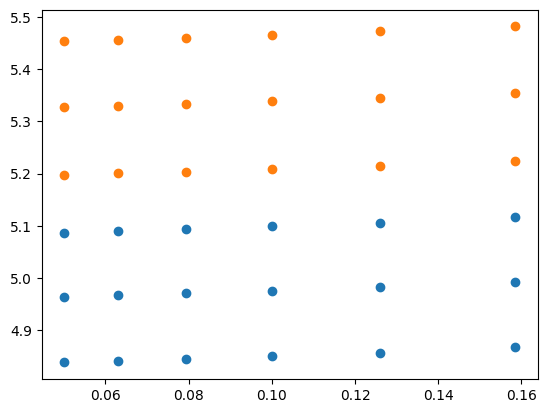

In [110]:
plt.scatter(result_air['AR inclusion (air)'],
         result_air['Vp (air)'])
plt.scatter(result_water['AR inclusion (water)'],
         result_water['Vp (water)'])

In [ ]:
fluid_list = ['air', 'water', 'oil']

for fluid in fluid_list:
    data_fluid = {
        f'C11_{fluid}': globals()[f'c11_{fluid}'],
        f'C12_{fluid}': globals()[f'c12_{fluid}'],
        f'C44_{fluid}': globals()[f'c44_{fluid}']
    }
    globals()[f'inversion_{fluid}'] = pd.DataFrame(data_fluid)

    if fluid == 'air':
        globals()[f'inversion_{fluid}'][f'Density ({fluid})'] = data['Density (air)'][idx]
    else:
        globals()[f'inversion_{fluid}'][f'Density ({fluid})'] = data['Density (water)'][idx]

    density =  data[f'Density {fluid}'][idx]
    Vp_exp, Vs_exp = data[f'Vp {fluid}'][idx], data[f'Vs {fluid}'][idx]
    porosity = data['Porosity,%'][idx]/100

### Vp, Vs calculation
    globals()[f'inversion_{fluid}'][f'Vp {fluid}'] = globals()[f'inversion_{fluid}'][[f'C11_{fluid}']].\
    apply(lambda x: np.sqrt(x[0] / density), axis=1)
    globals()[f'inversion_{fluid}'][f'Vs {fluid}'] = globals()[f'inversion_{fluid}'][[f'C44_{fluid}']].\
    apply(lambda x: np.sqrt(x[0] / density), axis=1)
### Aspect ratio
    globals()[f'inversion_{fluid}']['AR inclusion'] = np.round(AR_loop, 3)
### Crack density
    ### Если crack density > 1, то в породе преобладают монетообразные трещины,
    ### значит порода может потерять свою целостность. Следовательно, определять
    ### эффективные свойства породы имеет смысл лишь при rack density < 1 .
    globals()[f'inversion_{fluid}']['Crack density'] = np.round(3*porosity/(4*np.pi*AR_loop), 3)

### Relative diffrence between calculated and experimntal velocities
    globals()[f'inversion_{fluid}'][f'Diff Vp {fluid}'] = globals()[f'inversion_{fluid}'][[f'Vp {fluid}']]\
     .apply(lambda x: np.round((x[0] - Vp_exp)/Vp_exp*100, 2), axis=1)
    globals()[f'inversion_{fluid}'][f'Diff Vs {fluid}'] =globals()[f'inversion_{fluid}'][[f'Vs {fluid}']]\
    .apply(lambda x: np.round((x[0] - Vs_exp)/Vs_exp*100, 2), axis=1)

### Common relative diffrence between calculated and experimntal velocities
    globals()[f'inversion_{fluid}'][f'Diff'] = globals()[f'inversion_{fluid}']\
    .apply(lambda row: np.round(np.sqrt((row[f'Diff Vp {fluid}'])**2 + (row[f'Diff Vs {fluid}'])**2), 2), axis=1)

    ### sort values
    globals()[f'inversion_{fluid}'] = globals()[f'inversion_{fluid}'].sort_values(by=f'Diff')
